In [1]:
#                                                               1. Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder
import gc

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [ ]:
#                                                                 2. Reading Data

In [48]:
# Reading Data
input_file = "Sub1_ Adi.csv"
df = pd.read_csv(input_file)

# Looking for Activity column 
activity_col = [c for c in df.columns if 'activity' in c.lower()]
if not activity_col:
    raise ValueError("No 'activity' column found in dataset!")
activity_col = activity_col[0]

# Loading all the Column Names in sensor_cols
sensor_cols = [c for c in df.columns if c!=activity_col and np.issubdtype(df[c].dtype,np.number)]

In [ ]:
#                                                                 3. Missing Values                                      

In [50]:
df_clean = df.copy()

num = df_clean[sensor_cols].select_dtypes(include="number")
has_nan = df_clean[sensor_cols].isna().any().any()
has_inf = np.isinf(num.to_numpy()).any()

print(has_nan)
print(has_inf)
if has_nan or has_inf:
    # Optional: normalize infs to NaN first
    df_clean[sensor_cols] = df_clean[sensor_cols].replace([np.inf, -np.inf], np.nan)
    df_clean[sensor_cols] = df_clean[sensor_cols].interpolate(method="linear", limit_direction="both")
    before_rows = len(df_clean)
    df_clean = df_clean.dropna(subset=sensor_cols)
    after_rows = len(df_clean)
    df = df_clean
    print(f"Missing-value handling: dropped {before_rows - after_rows} rows after interpolation")
else:
    del df_clean
    gc.collect()
    print("No NaN/±Inf found; no interpolation or drops performed.")

False
False
No NaN/±Inf found; no interpolation or drops performed.


In [ ]:
#                                                                 4. Window Creation

In [52]:
###           Window parameters
window_size = 128
step_size = window_size // 2  # 50% overlap
sampling_rate = 50  # Hz
window_seconds = window_size / sampling_rate
majority_threshold = 0.80 
print(f"Window: {window_size} samples ({window_seconds:.2f} seconds) at {sampling_rate} Hz")
print(f"Hop: {step_size} samples (50% overlap)")
print(f"Class-consistency threshold: {int(majority_threshold*100)}%")

# Padding mode: "mirror", "mean", or "linear"
padding_mode = "mirror"
print(f"Padding mode: {padding_mode} (no cross-class borrowing)")

###           Padding utilities
def pad_series_to_length(vals: np.ndarray, target_len: int, mode: str, seg_mean: float | None = None) -> np.ndarray:
    L = len(vals)
    if L == target_len:
        return vals
    if L == 0:
        if mode == "mean" and seg_mean is not None:
            return np.full(target_len, seg_mean, dtype=float)
        return np.zeros(target_len, dtype=float)

    if mode == "linear":
        if L == 1:
            return np.full(target_len, vals[0], dtype=float)
        x_old = np.arange(L, dtype=float)
        x_new = np.linspace(0.0, L - 1, target_len)
        return np.interp(x_new, x_old, vals)

    if mode == "mirror":
        pad_len = target_len - L
        if L == 1:
            return np.pad(vals, (0, pad_len), mode="edge")
        return np.pad(vals, (0, pad_len), mode="reflect")

    if mode == "mean":
        if seg_mean is None:
            seg_mean = float(np.mean(vals)) if L > 0 else 0.0
        pad_vals = np.full(target_len - L, seg_mean, dtype=float)
        return np.concatenate([vals, pad_vals], axis=0)

    raise ValueError(f"Unknown padding mode: {mode}")

def build_row_from_window(win_df: pd.DataFrame,
                          sensor_columns: list[str],
                          target_len: int,
                          mode: str,
                          seg_means: pd.Series | None = None) -> dict:
    out = {}
    for col in sensor_columns:
        arr = win_df[col].to_numpy(dtype=float, copy=False)
        seg_mean = float(seg_means[col]) if (mode == "mean" and seg_means is not None) else None
        out[col] = pad_series_to_length(arr, target_len, mode, seg_mean=seg_mean).tolist()
    return out

###           Segment-aware windowing with padding only at segment edges

df_seg = df.copy()
seg_ids = (df_seg[activity_col] != df_seg[activity_col].shift()).cumsum()
df_seg["_segment_id"] = seg_ids

records = []
num_full = 0
num_tail_pads = 0
num_short_seg_pads = 0

for seg_id, seg_df in df_seg.groupby("_segment_id", sort=True):
    seg_df = seg_df.reset_index(drop=True)
    seg_label = seg_df.loc[0, activity_col]
    seg_len = len(seg_df)

    # Precompute per-segment means for "mean" padding
    seg_means = seg_df[sensor_cols].mean() if padding_mode == "mean" else None

    if seg_len < window_size:
        # Entire segment is shorter than a full window: take it once and pad
        row_data = build_row_from_window(seg_df, sensor_cols, window_size, padding_mode, seg_means)
        row_data["activity"] = seg_label
        records.append(row_data)
        num_short_seg_pads += 1
        continue

    # Full windows strictly inside the segment
    last_start = -step_size
    for s in range(0, seg_len - window_size + 1, step_size):
        e = s + window_size
        win = seg_df.iloc[s:e]
        # Optional: class-consistency check (should be 100% within a segment)
        class_frac = 1.0  # by construction
        if class_frac >= majority_threshold:
            row_data = {col: win[col].to_numpy(dtype=float).tolist() for col in sensor_cols}
            row_data["activity"] = seg_label
            records.append(row_data)
            num_full += 1
        last_start = s

    # Tail remainder at the end of the segment: pad to full length
    next_s = last_start + step_size
    if next_s < seg_len:
        win_short = seg_df.iloc[next_s:seg_len]
        if 0 < len(win_short) < window_size:
            row_data = build_row_from_window(win_short, sensor_cols, window_size, padding_mode, seg_means)
            row_data["activity"] = seg_label
            records.append(row_data)
            num_tail_pads += 1

#  Build final dataset with label as last column and save

df_windows = pd.DataFrame(records)

# Integrity: all sensor arrays should be window_size long
if not df_windows.empty:
    for col in sensor_cols:
        assert df_windows[col].map(len).eq(window_size).all(), f"{col} has non-uniform window lengths"

# Ensure class label is last column in the saved dataset
save_cols = sensor_cols + ["activity"]
df_save = df_windows[save_cols].copy()

print(f"Created {len(df_save)} windows: full={num_full}, tail-padded={num_tail_pads}, short-segment-padded={num_short_seg_pads}")
output_windows = "Sub1_windows_.csv"
df_save.to_csv(output_windows, index=False)
print(f"Saved windowed data to '{output_windows}' (label is last column)")

Window: 128 samples (2.56 seconds) at 50 Hz
Hop: 64 samples (50% overlap)
Class-consistency threshold: 80%
Padding mode: mirror (no cross-class borrowing)
Created 118 windows: full=112, tail-padded=6, short-segment-padded=0
Saved windowed data to 'Sub1_windows_.csv' (label is last column)


In [ ]:
#                                                       5. Data Scaling (Normalization & Standardization)

In [54]:
# Using 4 methods for scaling (keep your scalers dict as-is)
scalers = {
    'minmax': MinMaxScaler(),
    'standard': StandardScaler(),
    'robust': RobustScaler(),
    'MaxAbs': MaxAbsScaler()
}

# SCALE THE CLEANED + WINDOWED (PADDED) DATA
scaled_window_datasets = {}

for scaler_name, scaler in scalers.items():
    print(f"\nScaling padded windows with: {scaler_name}")

    # Fit on the full cleaned dataset (not per window) to keep a global scaling reference
    scaler.fit(df[sensor_cols].to_numpy(dtype=float))

    rows = []
    for wid, row in df_windows.iterrows():
        # Build window matrix (window_size x n_channels) from list-valued columns
        Xw = np.column_stack([np.asarray(row[c], dtype=float) for c in sensor_cols])  # shape: (window_size, n_channels)

        # Scale the window
        Xw_scaled = scaler.transform(Xw)

        # Store as long-form with _window_id and label for later groupby/feature extraction
        dfw = pd.DataFrame(Xw_scaled, columns=sensor_cols)
        dfw["_window_id"] = int(wid)
        dfw[activity_col] = row["activity"]
        rows.append(dfw)

    # Combine all scaled windows
    df_scaled_windows = pd.concat(rows, ignore_index=True)

    # Keep in memory for downstream steps
    scaled_window_datasets[scaler_name] = df_scaled_windows

    # Optional: reorder columns with label last (and keep _window_id before it)
    out_cols = sensor_cols + ["_window_id", activity_col]
    df_scaled_windows[out_cols].to_csv(f"Sub1_windows_scaled_{scaler_name}.csv", index=False)

    print(f"Saved: Sub1_windows_scaled_{scaler_name}.csv | Windows: {len(df_windows)} | Rows: {len(df_scaled_windows)}")


Scaling padded windows with: minmax
Saved: Sub1_windows_scaled_minmax.csv | Windows: 118 | Rows: 15104

Scaling padded windows with: standard
Saved: Sub1_windows_scaled_standard.csv | Windows: 118 | Rows: 15104

Scaling padded windows with: robust
Saved: Sub1_windows_scaled_robust.csv | Windows: 118 | Rows: 15104

Scaling padded windows with: MaxAbs
Saved: Sub1_windows_scaled_MaxAbs.csv | Windows: 118 | Rows: 15104


In [ ]:
#                                                           6. Compare Before/After Scaling

In [56]:
print("Before Scaling:")
print(df[sensor_cols].describe().loc[['mean','std','min','max']])

for name, df_scaled_i in scaled_window_datasets.items():
    print(f"\nAfter {name} scaling:")
    print(df_scaled_i[sensor_cols].describe().loc[['mean','std','min','max']])

Before Scaling:
           AG-X       AG-Y       AG-Z      Acc-X      Acc-Y      Acc-Z  \
mean   0.819563   7.636694   2.635801   0.082620   0.089457  -0.122888   
std    3.611846   8.631601   6.497665   3.228465   7.446315   5.751377   
min  -46.830242 -58.473630 -47.113945 -34.084150 -57.279514 -51.218113   
max   40.053764  88.033840  74.791954  29.574244  74.486090  82.690630   

      Gravity-X  Gravity-Y  Gravity-Z       RR-X       RR-Y      RR-Z  \
mean   0.788283   7.648029   2.737674   0.053527  -0.096750 -0.063871   
std    1.639326   3.295560   4.002191   1.982822   1.990449  0.681375   
min   -8.855526  -9.495202  -5.945140 -11.874129 -16.312906 -6.039924   
max    6.940621   9.806541   9.763872  16.190237  19.739874  7.211954   

          RV-X      RV-Y      RV-Z       cos  
mean  0.371707 -0.134788  0.061867  0.510146  
std   0.263457  0.369336  0.577272  0.201502  
min  -0.815862 -0.838608 -0.964206  0.001199  
max   0.877052  0.843295  0.957350  0.935604  

After minma

In [ ]:
#                                                             6.1 Visualize Effects of Scaling

In [58]:
# Use only 1 sample per window

# Instead of plotting all rows in the scaled windows, take the mean per window:

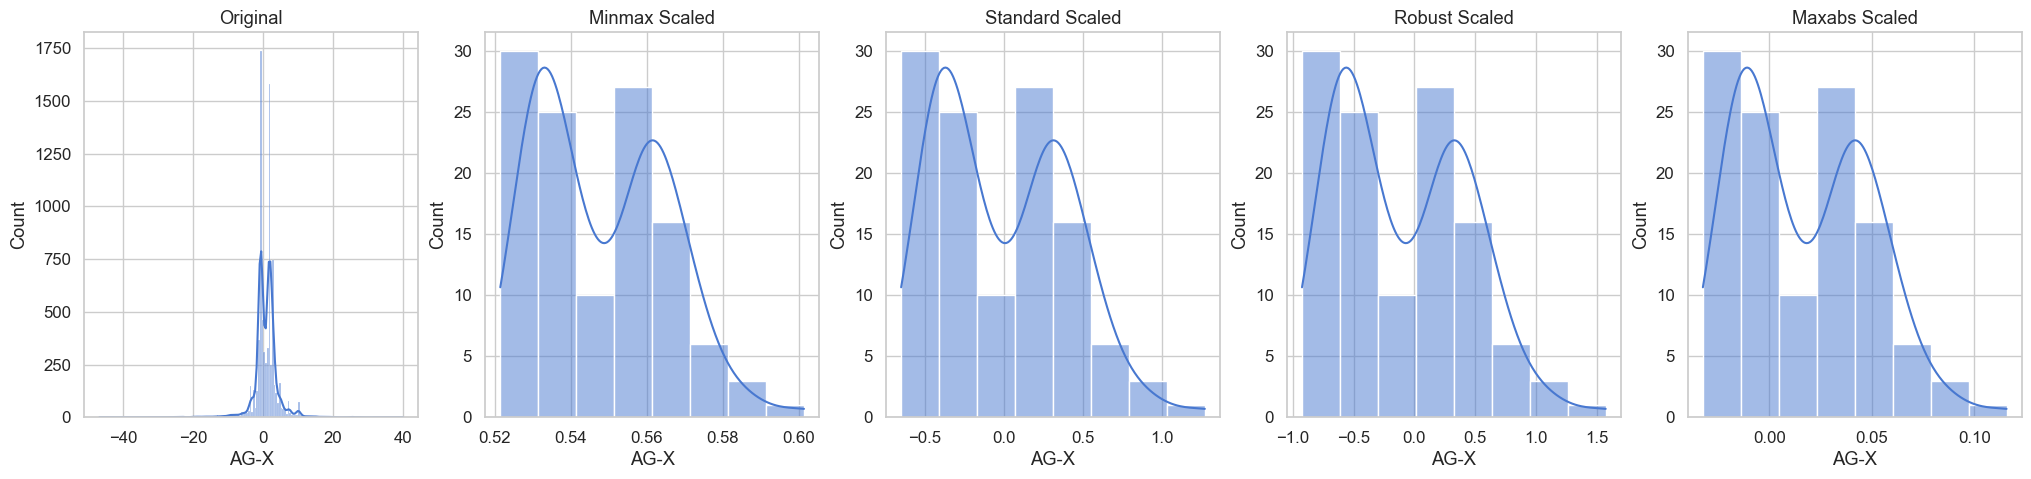

In [59]:
# 6.1 Visualize Effects of Scaling
feature = 'AG-X'
if feature not in df.columns:
    feature = sensor_cols[0]

fig, axes = plt.subplots(1, len(scaled_window_datasets)+1, figsize=(25,5))
sns.histplot(df[feature], ax=axes[0], kde=True)
axes[0].set_title("Original")

for i, (name, df_scaled_i) in enumerate(scaled_window_datasets.items(), start=1):
    per_window_means = df_scaled_i.groupby("_window_id")[feature].mean()
    sns.histplot(per_window_means, ax=axes[i], kde=True)
    axes[i].set_title(name.capitalize() + " Scaled")
plt.show()

In [60]:
###    Chosen Scaling Technique: Robust Scaler

###    After applying and comparing multiple scaling techniques Min–Max Scaling, Standard Scaling (Z-score), 
###    MaxAbs Scaling and Robust Scalin. We selected the Robust Scaler as the final 
###    normalization method for subsequent feature extraction and modeling.

###    This decision was based on both statistical summaries (mean, standard deviation, and range) and
###    visual analysis (histograms and boxplots). While Min–Max and Standard scaling methods successfully
###    rescaled the data, they were sensitive to outliers, which are common in motion and sensor datasets 
###    due to sudden spikes or noise. In contrast, the Robust Scaler centers the data around the median and
###    scales it according to the interquartile range (IQR), making it less influenced by extreme values.

###    By using Robust Scaling, we ensured that all sensor channels contributed more equally to the model 
###    without distortion from outlier values preserving the general data distribution while improving model
###    stability and convergence during training.

In [ ]:
#                                                                 7. Extracing Features

In [62]:
#Selectiong robust-scaled data
df_scaled = scaled_window_datasets['robust']
# Sensor columns (reconfirm after df_scaled is set)
sensor_cols = [c for c in df_scaled.columns if c not in (activity_col, "_window_id")]

def extract_features(window_df, sensor_cols=sensor_cols):
    features = {}
    for col in sensor_cols:
        # Ensure numeric dtype and avoid copies where possible
        data = window_df[col].to_numpy(dtype=float, copy=False)
        n = len(data)
        diffs = np.diff(data) if n > 1 else np.array([0.0], dtype=float)

        # --- Basic Stats ---
        features[f'{col}_mean']   = float(np.mean(data))
        features[f'{col}_median'] = float(np.median(data))
        features[f'{col}_std']    = float(np.std(data))
        features[f'{col}_var']    = float(np.var(data))
        features[f'{col}_min']    = float(np.min(data))
        features[f'{col}_max']    = float(np.max(data))
        features[f'{col}_range']  = float(np.ptp(data))
        features[f'{col}_iqr']    = float(np.percentile(data, 75) - np.percentile(data, 25))

        # Skew/kurt can be NaN for constant signals; coerce to 0
        sk = pd.Series(data).skew()
        ku = pd.Series(data).kurt()
        features[f'{col}_skew'] = 0.0 if np.isnan(sk) else float(sk)
        features[f'{col}_kurt'] = 0.0 if np.isnan(ku) else float(ku)

        # --- Advanced Features ---
        features[f'{col}_rms']    = float(np.sqrt(np.mean(data**2)))
        features[f'{col}_mad']    = float(np.mean(np.abs(data - np.mean(data))))  # Mean Absolute Deviation
        features[f'{col}_sma']    = float(np.mean(np.abs(data)))                  # Signal Magnitude Area
        features[f'{col}_energy'] = float(np.sum(data**2))                        # Energy

        # Zero-crossing rate: use len-1 to avoid overcount and guard n<2
        zcr_den = max(n - 1, 1)
        features[f'{col}_zcr'] = float(((data[:-1] * data[1:]) < 0).sum()) / zcr_den

        # --- Autocorrelation (lag-1) ---
        if n > 1:
            data_mean = data - np.mean(data)
            autocorr = np.correlate(data_mean, data_mean, mode='full')
            autocorr = autocorr[autocorr.size // 2:]  # non-negative lags
            denom = autocorr[0]
            if denom != 0 and len(autocorr) > 1:
                features[f'{col}_autocorr_lag1'] = float(autocorr[1] / denom)
            else:
                features[f'{col}_autocorr_lag1'] = 0.0
        else:
            features[f'{col}_autocorr_lag1'] = 0.0

        # --- Hjorth Parameters ---
        activity = np.var(data)
        if activity > 0:
            var_diffs = np.var(diffs)
            mobility = np.sqrt(var_diffs / activity) if var_diffs >= 0 else 0.0
        else:
            mobility = 0.0
        if mobility > 0:
            var_diffs2 = np.var(np.diff(diffs)) if len(diffs) > 1 else 0.0
            complexity = np.sqrt(var_diffs2 / np.var(diffs)) / mobility if np.var(diffs) > 0 else 0.0
        else:
            complexity = 0.0
        features[f'{col}_hjorth_activity']   = float(activity)
        features[f'{col}_hjorth_mobility']   = float(mobility)
        features[f'{col}_hjorth_complexity'] = float(complexity)

        # --- Peak Count ---
        std_val = np.std(data)
        prominence = std_val * 0.5 if std_val > 0 else None  # avoid forcing 0 prominence on flat signals
        peaks, _ = find_peaks(data, prominence=prominence)
        features[f'{col}_peak_count'] = int(len(peaks))

    return features

# Extract features window-wise (hardened)
feature_records = []
for wid, window in df_scaled.groupby("_window_id", sort=True):
    # Optional sanity check (skip malformed windows)
    if len(window) != window_size:
        # You can log/print if you want to know this happened
        continue

    class_counts = window[activity_col].value_counts(normalize=True)
    if class_counts.iloc[0] < majority_threshold:
        continue

    window_features = extract_features(window)
    window_features[activity_col] = class_counts.index[0]
    feature_records.append(window_features)

df_features = pd.DataFrame(feature_records)
df_features.to_csv("Sub1_features_robust_full.csv", index=False)
print(f"Features extracted and saved: Sub1_features_robust_full.csv | Windows: {len(feature_records)}")

Features extracted and saved: Sub1_features_robust_full.csv | Windows: 118


In [ ]:
#                                                                7.1 Graph

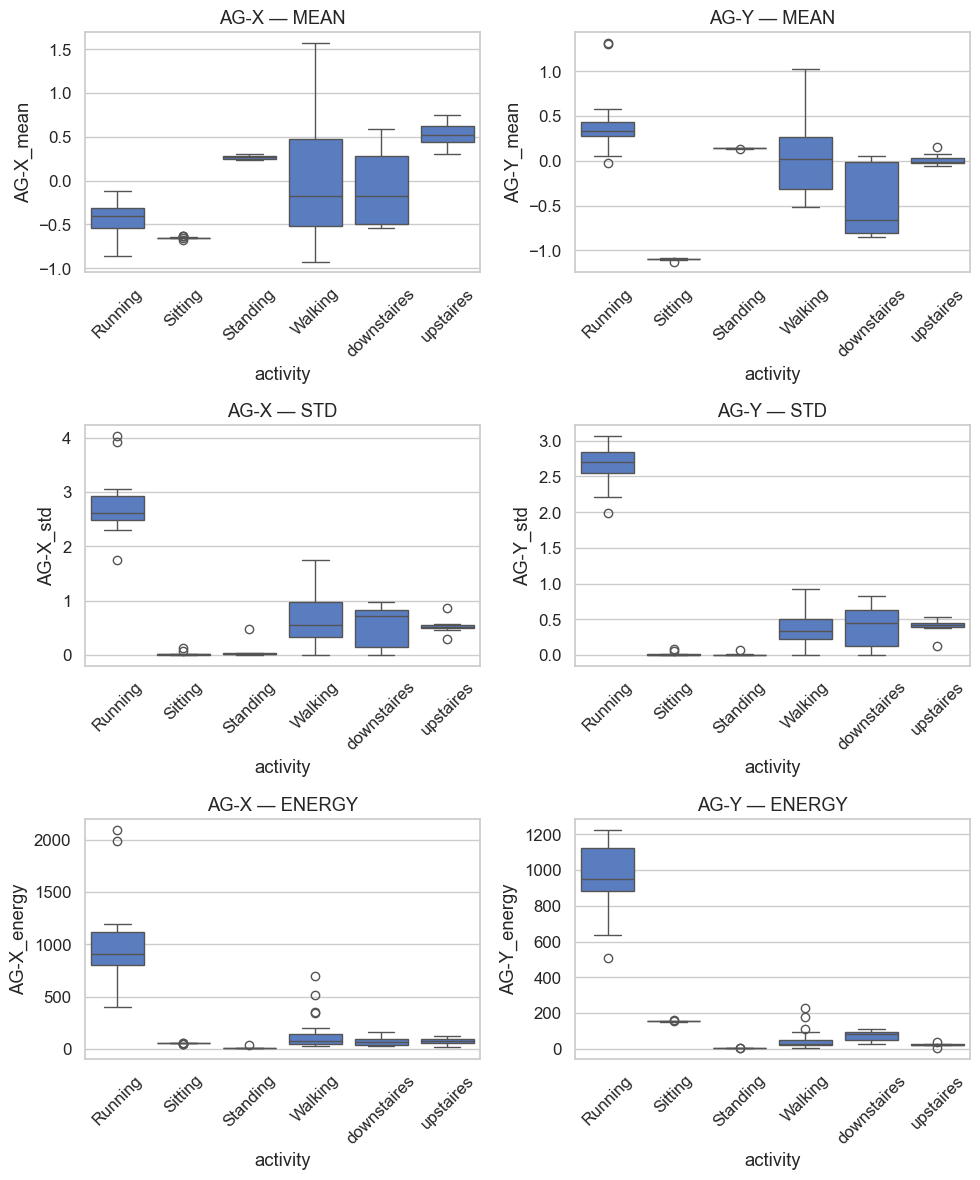

In [77]:
# Plot three features per channel: mean, std, energy
# Arrange as rows = features (3), columns = channels (e.g., AG-X, AG-Y)

features_to_plot = ["mean", "std", "energy"]

# Choose channels explicitly if present; otherwise fallback to first two sensor columns
preferred_channels = ["AG-X", "AG-Y"]
channels_to_plot = [ch for ch in preferred_channels if ch in sensor_cols]
if len(channels_to_plot) == 0:
    channels_to_plot = sensor_cols[:2]  # fallback

if len(channels_to_plot) > 0:
    rows = len(features_to_plot)   # 3
    cols = len(channels_to_plot)

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), squeeze=False)

    for ci, ch in enumerate(channels_to_plot):
        for ri, feat in enumerate(features_to_plot):
            ax = axes[ri, ci]
            colname = f"{ch}_{feat}"
            if colname in df_features.columns:
                sns.boxplot(data=df_features, x=activity_col, y=colname, ax=ax)
                ax.set_title(f"{ch} — {feat.upper()}")
                ax.tick_params(axis='x', rotation=45)
            else:
                # Hide if the feature column doesn't exist
                ax.set_visible(False)

    # Hide any unused axes if something was missing (not expected here, but safe)
    for r in range(rows):
        for c in range(cols):
            if not axes[r, c].has_data():
                axes[r, c].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("No channels available to plot.")

In [ ]:
#                                                              8.Feature Selection

In [69]:
# 1. Prepare X and y
if df_features.empty:
    raise ValueError("df_features is empty. Ensure feature extraction produced rows before selection.")

X = df_features.drop(columns=[activity_col])
y = df_features[activity_col]

# Encode labels numerically (for MI only)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 2. Variance Threshold
var_thresh = 1e-5  # remove near-constant features
vt = VarianceThreshold(threshold=var_thresh)
X_vt = vt.fit_transform(X)
selected_features_vt = X.columns[vt.get_support()].tolist()
df_vt = pd.DataFrame(X_vt, columns=selected_features_vt, index=X.index)
df_vt[activity_col] = y
print(f"Variance Threshold: retained {len(selected_features_vt)} features")

df_vt.to_csv("Sub1_features_after_variance_threshold.csv", index=False)


# 3. Pearson's Correlation
corr_matrix = df_vt.drop(columns=[activity_col]).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if (upper[col] > 0.9).any()]
df_corr = df_vt.drop(columns=to_drop)
print(f"Pearson Correlation: dropped {len(to_drop)} features, remaining {df_corr.shape[1]-1}")
df_corr.to_csv("Sub1_features_after_correlation.csv", index=False)


# 4. Information Gain (Mutual Information)
X_corr = df_corr.drop(columns=[activity_col])
# random_state is supported in recent scikit-learn; remove if your version doesn't support it
mi = mutual_info_classif(X_corr, y_encoded, discrete_features=False, random_state=42)
mi_series = pd.Series(mi, index=X_corr.columns).sort_values(ascending=False)
top_k = 30 if len(mi_series) > 30 else len(mi_series)
top_features_ig = mi_series.head(top_k).index.tolist()
df_ig = df_corr[top_features_ig + [activity_col]]
print(f"Information Gain: selected top {len(top_features_ig)} features")
df_ig.to_csv("Sub1_features_after_information_gain.csv", index=False)


# 5. Fisher Score
def fisher_score(X, y):
    scores = {}
    classes = np.unique(y)
    overall_mean = X.mean()
    for col in X.columns:
        numerator = sum([len(X[y == c]) * (X[y == c][col].mean() - overall_mean[col])**2 for c in classes])
        denominator = sum([((X[y == c][col] - X[y == c][col].mean())**2).sum() for c in classes])
        scores[col] = numerator / denominator if denominator != 0 else 0
    return pd.Series(scores).sort_values(ascending=False)

X_ig = df_ig.drop(columns=[activity_col])
fisher_scores = fisher_score(X_ig, df_ig[activity_col])
top_features_fs = fisher_scores.head(16).index.tolist()
df_final = df_ig[top_features_fs + [activity_col]]
print(f"Fisher Score: final selected {len(top_features_fs)} features")
df_final.to_csv("Sub1_features_final_fisher.csv", index=False)


# 6. Feature Selection Summary
print("\nFeature Selection Summary:")
print(f"Step 1 - Variance Threshold: {len(selected_features_vt)} features")
print(f"Step 2 - Pearson Correlation: {df_corr.shape[1]-1} features")
print(f"Step 3 - Information Gain: {len(top_features_ig)} features")
print(f"Step 4 - Fisher Score: {len(top_features_fs)} features")

# Optional: persist the selected feature lists and label classes
pd.Series(selected_features_vt).to_csv("selected_features_variance_threshold.csv", index=False)
pd.Series(top_features_ig).to_csv("selected_features_information_gain.csv", index=False)
pd.Series(top_features_fs).to_csv("selected_features_final_fisher.csv", index=False)
np.save("label_classes.npy", le.classes_)

Variance Threshold: retained 320 features
Pearson Correlation: dropped 180 features, remaining 140
Information Gain: selected top 30 features
Fisher Score: final selected 16 features

Feature Selection Summary:
Step 1 - Variance Threshold: 320 features
Step 2 - Pearson Correlation: 140 features
Step 3 - Information Gain: 30 features
Step 4 - Fisher Score: 16 features


In [ ]:
#                                                             9. Pipline Summary

In [76]:
import json
from datetime import datetime,timezone


scaled_summary = {}
for name, d in scaled_window_datasets.items():
    if d.empty:
        scaled_summary[name] = {"num_windows": 0, "rows": 0}
    else:
        sizes = d.groupby("_window_id").size()
        scaled_summary[name] = {
            "num_windows": int(sizes.size),
            "rows": int(len(d)),
            "rows_per_window_expected": int(window_size),
            "rows_per_window_min": int(sizes.min()),
            "rows_per_window_max": int(sizes.max()),
        }

params = {
    "generated_at_utc":datetime.now(timezone.utc).isoformat(timespec="seconds").replace("+00:00", "Z"),

    "input_file": input_file,
    "activity_col": activity_col,
    "sensor_cols": sensor_cols,
    "sampling_rate_hz": sampling_rate,
    "window_size_samples": window_size,
    "window_size_seconds": window_seconds,
    "hop_size_samples": step_size,
    "overlap_ratio": 1.0 - (step_size / window_size),
    "majority_threshold": majority_threshold,
    "padding_mode": padding_mode,
    "segment_window_counts": {
        "full": int(num_full),
        "tail_padded": int(num_tail_pads),
        "short_segment_padded": int(num_short_seg_pads),
        "total_windows": int(len(df_windows)),
    },
    "scalers_applied": list(scalers.keys()),
    "chosen_scaler_for_features": "robust",
    "scaled_datasets_summary": scaled_summary,
    "class_distribution_on_windows": df_windows["activity"].value_counts().to_dict(),
    "artifacts": {
        "padded_windows_csv": output_windows,
        "scaled_windows_csvs": {name: f"Sub1_windows_scaled_{name}.csv" for name in scaled_window_datasets.keys()},
        "features_csv": "Sub1_features_robust_full.csv",
        "features_after_variance_threshold": "Sub1_features_after_variance_threshold.csv",
        "features_after_correlation": "Sub1_features_after_correlation.csv",
        "features_after_information_gain": "Sub1_features_after_information_gain.csv",
        "features_final_fisher": "Sub1_features_final_fisher.csv",
        "selected_features_lists": {
            "variance_threshold": "selected_features_variance_threshold.csv",
            "information_gain": "selected_features_information_gain.csv",
            "final_fisher": "selected_features_final_fisher.csv",
        },
        "label_classes_npy": "label_classes.npy",
    },
}

with open("Sub1_pipeline_params.json", "w") as f:
    json.dump(params, f, indent=2)

print("Saved pipeline metadata to Sub1_pipeline_params.json")

Saved pipeline metadata to Sub1_pipeline_params.json
